In [60]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

pd.set_option("display.max_columns", 200)
sns.set(style="whitegrid")


In [61]:
# Helper
def make_ohe():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        # older sklearn
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

In [16]:
# Load data
df = pd.read_csv("Airline_Delay_Cause.csv")

In [17]:
# Basic EDA
print(df.shape)              # rows, columns
print(df.info())             # datatypes, missing values
print(df.describe())         # summary statistics
print(df.isnull().sum())     # null counts
print(df.duplicated().sum()) # check duplicates

(9453, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9453 entries, 0 to 9452
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year                 9453 non-null   int64  
 1   month                9453 non-null   int64  
 2   carrier              9453 non-null   object 
 3   carrier_name         9453 non-null   object 
 4   airport              9453 non-null   object 
 5   airport_name         9453 non-null   object 
 6   arr_flights          9452 non-null   float64
 7   arr_del15            9450 non-null   float64
 8   carrier_ct           9452 non-null   float64
 9   weather_ct           9452 non-null   float64
 10  nas_ct               9452 non-null   float64
 11  security_ct          9452 non-null   float64
 12  late_aircraft_ct     9452 non-null   float64
 13  arr_cancelled        9452 non-null   float64
 14  arr_diverted         9452 non-null   float64
 15  arr_delay            9452 n

In [18]:
df.head()

,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2025,5,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",92.0,17.0,4.80,1.24,4.29,0.0,6.67,4.0,2.0,1834.0,517.0,555.0,283.0,0.0,479.0
1,2025,5,9E,Endeavor Air Inc.,AEX,"Alexandria, LA: Alexandria International",92.0,24.0,10.74,3.65,4.57,0.0,5.03,2.0,1.0,2080.0,615.0,917.0,186.0,0.0,362.0
2,2025,5,9E,Endeavor Air Inc.,AGS,"Augusta, GA: Augusta Regional at Bush Field",188.0,52.0,17.87,1.49,12.97,0.0,19.67,4.0,1.0,4132.0,956.0,538.0,898.0,0.0,1740.0
3,2025,5,9E,Endeavor Air Inc.,ALB,"Albany, NY: Albany International",83.0,26.0,6.01,0.00,2.88,0.0,17.11,4.0,0.0,1975.0,857.0,0.0,83.0,0.0,1035.0
4,2025,5,9E,Endeavor Air Inc.,ATL,"Atlanta, GA: Hartsfield-Jackson Atlanta Intern...",3118.0,785.0,146.76,26.61,200.27,0.0,411.36,43.0,8.0,67705.0,19313.0,3384.0,10047.0,0.0,34961.0


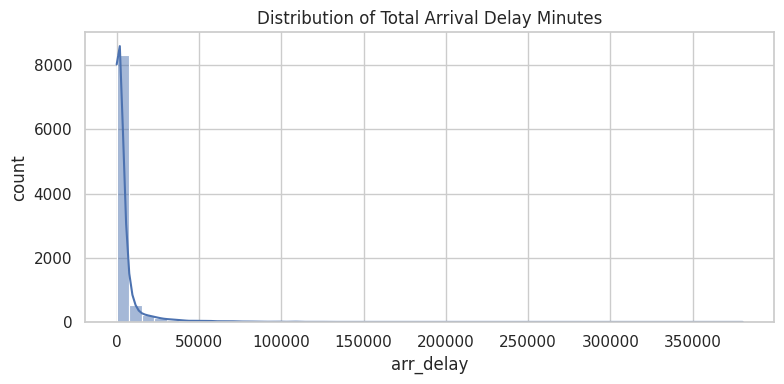

In [62]:
# Visualize
if "arr_delay" in df.columns:
    plt.figure(figsize=(8,4))
    sns.histplot(df["arr_delay"].dropna(), bins=50, kde=True)
    plt.title("Distribution of Total Arrival Delay Minutes")
    plt.xlabel("arr_delay")
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()

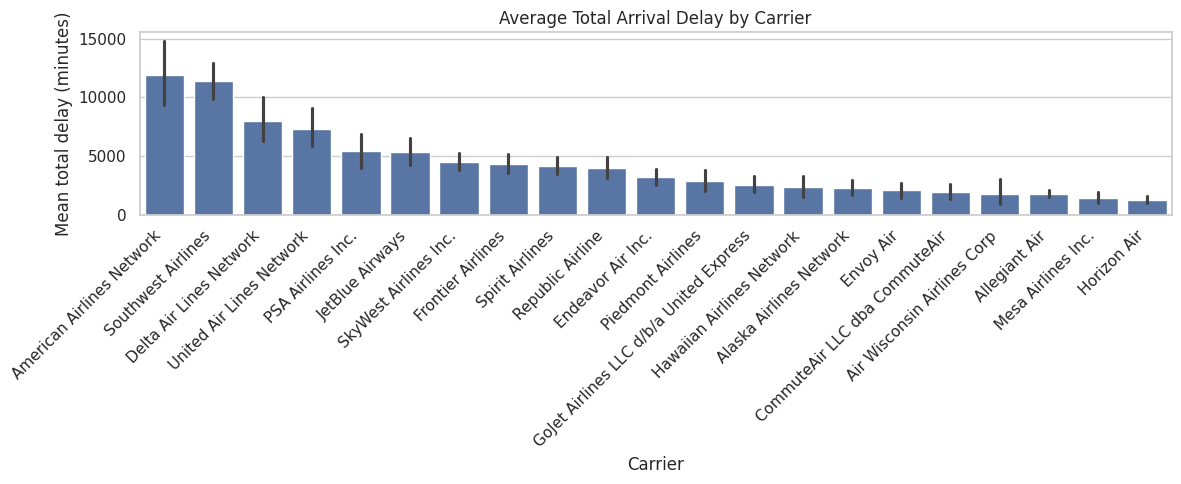

In [63]:
if "carrier_name" in df.columns and "arr_delay" in df.columns:
    plt.figure(figsize=(12,5))
    order = df.groupby("carrier_name")["arr_delay"].mean().sort_values(ascending=False).index
    sns.barplot(data=df, x="carrier_name", y="arr_delay", order=order, errorbar=("ci", 95))
    plt.title("Average Total Arrival Delay by Carrier")
    plt.xlabel("Carrier")
    plt.ylabel("Mean total delay (minutes)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

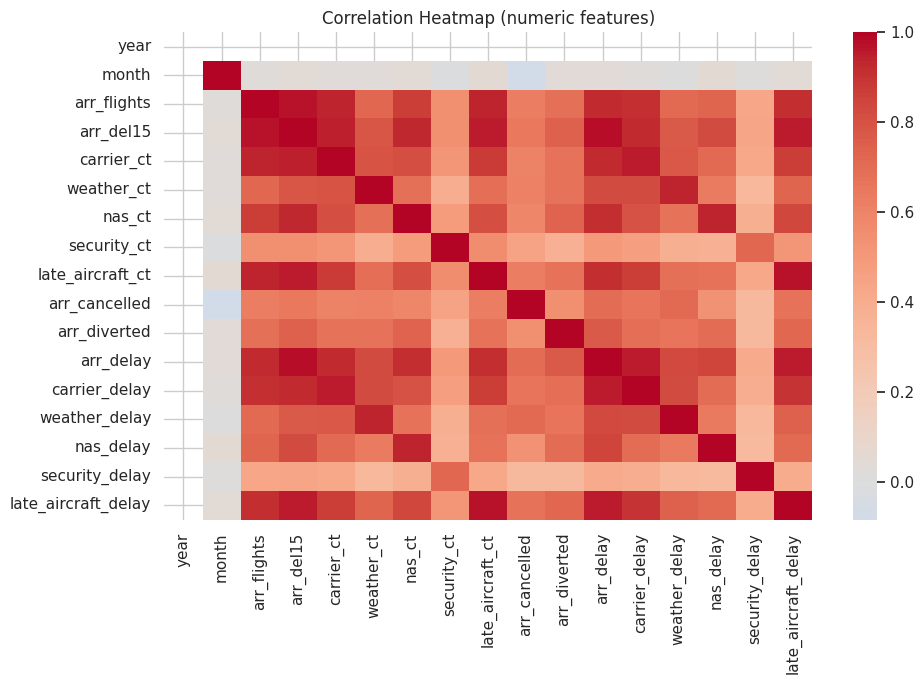

In [64]:
num_df = df.select_dtypes(include=[np.number])
if num_df.shape[1] >= 2:
    plt.figure(figsize=(10,7))
    corr = num_df.corr()
    sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
    plt.title("Correlation Heatmap (numeric features)")
    plt.tight_layout()
    plt.show()

In [65]:
# Build target for modeling
df = df.replace([np.inf, -np.inf], np.nan).copy()

if "arr_flights" not in df.columns or "arr_delay" not in df.columns:
    raise ValueError("Expected columns arr_flights and arr_delay in dataset.")

df["arr_flights"] = df["arr_flights"].replace(0, np.nan)
df["delay_per_flight"] = df["arr_delay"] / df["arr_flights"]


In [67]:
# Drop rows with missing target
before = len(df)
df = df[df["delay_per_flight"].notna()].copy()
print(f"Dropped {before - len(df)} rows with NaN delay_per_flight.")

Dropped 0 rows with NaN delay_per_flight.


In [68]:
# Features and target
y = df["delay_per_flight"].astype(float)

X = df.drop(columns=["delay_per_flight", "arr_delay"])  # drop arr_delay too

# Drop component delay columns that are parts of arr_delay
leak_cols = ["carrier_delay", "weather_delay", "nas_delay", "security_delay", "late_aircraft_delay"]
X = X.drop(columns=[c for c in leak_cols if c in X.columns], errors="ignore")

In [70]:
# Column typing
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print("Categorical columns:", cat_cols)
print("Numeric columns:", num_cols)

Categorical columns: ['carrier', 'carrier_name', 'airport', 'airport_name']
Numeric columns: ['year', 'month', 'arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct', 'arr_cancelled', 'arr_diverted']


In [71]:
# Preprocessing
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", make_ohe())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop"
)

In [72]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [73]:
# Linear regression pipeline
linreg = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)

In [75]:
# Metrics (min per flight)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Per-flight delay model performance:")
print(f"  RMSE: {rmse:.2f} minutes/flight")
print(f"  MAE : {mae:.2f} minutes/flight")
print(f"  R^2 : {r2:.3f}")

Per-flight delay model performance:
  RMSE: 16.85 minutes/flight
  MAE : 7.30 minutes/flight
  R^2 : -0.047


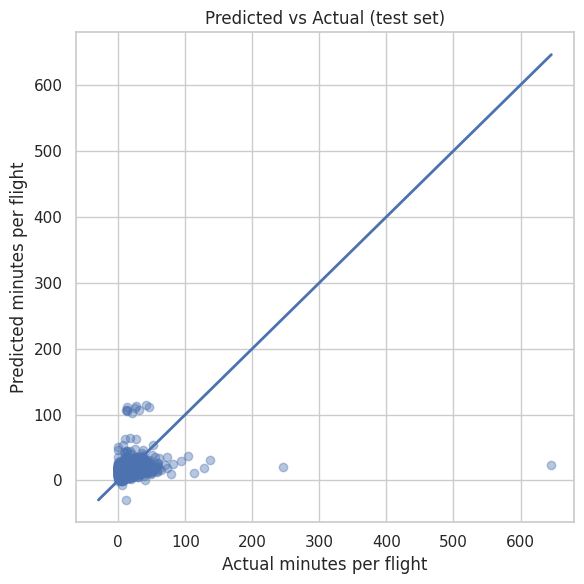

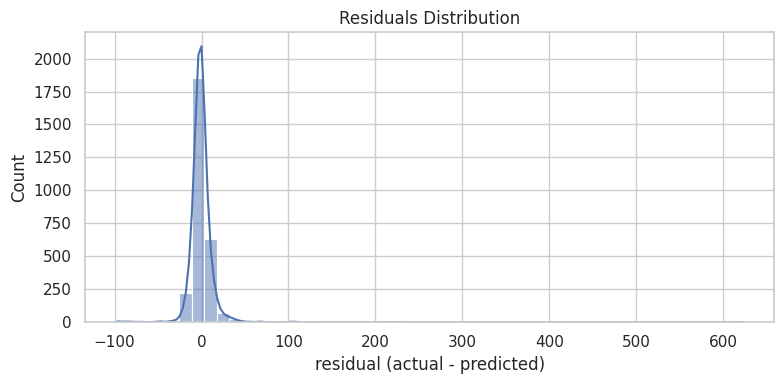

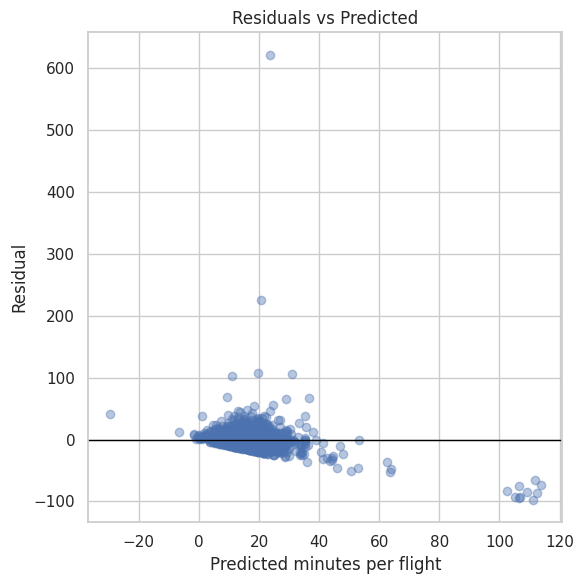

In [76]:
# Diagnostics
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.4)
m, M = float(np.min([y_test.min(), y_pred.min()])), float(np.max([y_test.max(), y_pred.max()]))
plt.plot([m, M], [m, M], lw=2)
plt.xlabel("Actual minutes per flight")
plt.ylabel("Predicted minutes per flight")
plt.title("Predicted vs Actual (test set)")
plt.tight_layout()
plt.show()

residuals = y_test - y_pred
plt.figure(figsize=(8,4))
sns.histplot(residuals, bins=50, kde=True)
plt.title("Residuals Distribution")
plt.xlabel("residual (actual - predicted)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(y_pred, residuals, alpha=0.4)
plt.axhline(0, color="black", lw=1)
plt.xlabel("Predicted minutes per flight")
plt.ylabel("Residual")
plt.title("Residuals vs Predicted")
plt.tight_layout()
plt.show()

In [80]:
# Prediction helper
feature_template = {}
for c in num_cols:
    feature_template[c] = X_train[c].median()
for c in cat_cols:
    m = X_train[c].mode(dropna=True)
    feature_template[c] = m.iat[0] if not m.empty else None

valid_cols = set(feature_template.keys())

def _known_categories_for(col):
    if col not in cat_cols:
        return None
    enc = linreg.named_steps["preprocessor"].named_transformers_["cat"].named_steps["encoder"]
    idx = cat_cols.index(col)
    return set(enc.categories_[idx])

def predict_delay_from_overrides(model_pipeline: Pipeline, template: dict, **overrides) -> float:

    bad_keys = [k for k in overrides if k not in valid_cols]
    if bad_keys:
        print(f"[WARN] Ignored unknown feature keys: {bad_keys}")

    row = template.copy()
    for k, v in overrides.items():
        if k in valid_cols:
            if k in cat_cols:
                known = _known_categories_for(k)
                if known is not None and v not in known:
                    # Warn but still allow; OHE will zero it due to handle_unknown="ignore"
                    print(f"[WARN] Unknown category for '{k}': {v!r}. "
                          f"Known examples: {list(sorted(list(known))[:8])} ...")
            row[k] = v

    X_one = pd.DataFrame([row])

    print("\n[Preview of row for prediction]")
    preview_cols = sorted(list(set(
        ["carrier_name","airport_name","year","month","arr_flights"] + list(overrides.keys())
    )))
    print(X_one[[c for c in preview_cols if c in X_one.columns]].T)

    pred = model_pipeline.predict(X_one)[0]
    return float(pred)  # minutes per flight

In [81]:
# Example predictions
ex1 = predict_delay_from_overrides(
    linreg, feature_template,
    carrier_name="Endeavor Air Inc.",
    airport_name="Atlanta, GA: Hartsfield-Jackson Atlanta International",
    year=2025, month=5
)
print(f"Predicted minutes per flight (example 1): {ex1:.2f}")


[Preview of row for prediction]
                                                              0
airport_name  Atlanta, GA: Hartsfield-Jackson Atlanta Intern...
arr_flights                                                91.0
carrier_name                                  Endeavor Air Inc.
month                                                         5
year                                                       2025
Predicted minutes per flight (example 1): 12.70


In [82]:

ex2 = predict_delay_from_overrides(
    linreg, feature_template,
    carrier_name="Endeavor Air Inc.",
    airport_name="Albany, NY: Albany International",
    year=2025, month=5,
    arr_flights=150.0
)
print(f"Predicted minutes per flight (example 2): {ex2:.2f}")


[Preview of row for prediction]
                                             0
airport_name  Albany, NY: Albany International
arr_flights                              150.0
carrier_name                 Endeavor Air Inc.
month                                        5
year                                      2025
Predicted minutes per flight (example 2): 12.39
